<a href="https://colab.research.google.com/github/Anjali04-15/GNN-AID_A/blob/main/gcn_fgsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.9 MB/s eta 0:00:00


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import networkx as nx

In [13]:
def fgsm_attack(model, data, epsilon=0.01, save_features=False):
    model.eval()
    data.x.requires_grad = True

    # Forward pass
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.test_mask], data.y[data.test_mask])

    model.zero_grad()
    loss.backward()

    # Get gradient of the loss wrt input features
    data_grad = data.x.grad.data

    # FGSM perturbation
    perturbed_x = data.x + epsilon * data_grad.sign()

    # Re-evaluate with perturbed features
    out_perturbed = model(perturbed_x, data.edge_index)
    pred = out_perturbed.argmax(dim=1)

    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    print(f"Accuracy under FGSM attack (epsilon={epsilon}): {acc:.4f}")

    # Optionally save perturbed features to disk
    if save_features:
        torch.save(perturbed_x, f"perturbed_features_eps{epsilon}.pt")
        print(f"Perturbed features saved as perturbed_features_eps{epsilon}.pt")

    return perturbed_x


In [14]:
# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [15]:
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]  # Get the first graph object

# Initialize model, optimizer, and loss function
model = GCN(in_channels=dataset.num_node_features, hidden_channels=16, out_channels=dataset.num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [16]:
# Training loop
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients
    out = model(data.x, data.edge_index)  # Forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    return loss.item()


In [17]:
# Evaluation function
def test():
    model.eval()
    with torch.no_grad():  # No gradients needed for evaluation
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # Get the predicted classes
        test_accuracy = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
        return test_accuracy.item()

In [18]:
# Run the training process
for epoch in range(200):  # Number of epochs
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

print("Training completed.")

import numpy as np
import plotly.graph_objs as go
import plotly.offline as pyo
import networkx as nx

Epoch: 0, Loss: 1.9482, Test Accuracy: 0.4790
Epoch: 10, Loss: 0.6382, Test Accuracy: 0.7950
Epoch: 20, Loss: 0.1031, Test Accuracy: 0.7800
Epoch: 30, Loss: 0.0202, Test Accuracy: 0.7820
Epoch: 40, Loss: 0.0073, Test Accuracy: 0.7830
Epoch: 50, Loss: 0.0041, Test Accuracy: 0.7810
Epoch: 60, Loss: 0.0029, Test Accuracy: 0.7810
Epoch: 70, Loss: 0.0024, Test Accuracy: 0.7810
Epoch: 80, Loss: 0.0021, Test Accuracy: 0.7800
Epoch: 90, Loss: 0.0018, Test Accuracy: 0.7790
Epoch: 100, Loss: 0.0016, Test Accuracy: 0.7790
Epoch: 110, Loss: 0.0015, Test Accuracy: 0.7790
Epoch: 120, Loss: 0.0014, Test Accuracy: 0.7780
Epoch: 130, Loss: 0.0012, Test Accuracy: 0.7800
Epoch: 140, Loss: 0.0011, Test Accuracy: 0.7790
Epoch: 150, Loss: 0.0011, Test Accuracy: 0.7790
Epoch: 160, Loss: 0.0010, Test Accuracy: 0.7780
Epoch: 170, Loss: 0.0009, Test Accuracy: 0.7790
Epoch: 180, Loss: 0.0008, Test Accuracy: 0.7790
Epoch: 190, Loss: 0.0008, Test Accuracy: 0.7780
Training completed.


Clean Test Accuracy (before attack): 0.7780
Accuracy under FGSM attack (epsilon=0.01): 0.2800
Perturbed features saved as perturbed_features_eps0.01.pt
Accuracy under FGSM attack (epsilon=0.05): 0.1160
Perturbed features saved as perturbed_features_eps0.05.pt
Accuracy under FGSM attack (epsilon=0.1): 0.1020
Perturbed features saved as perturbed_features_eps0.1.pt
Accuracy under FGSM attack (epsilon=0.2): 0.0950
Perturbed features saved as perturbed_features_eps0.2.pt


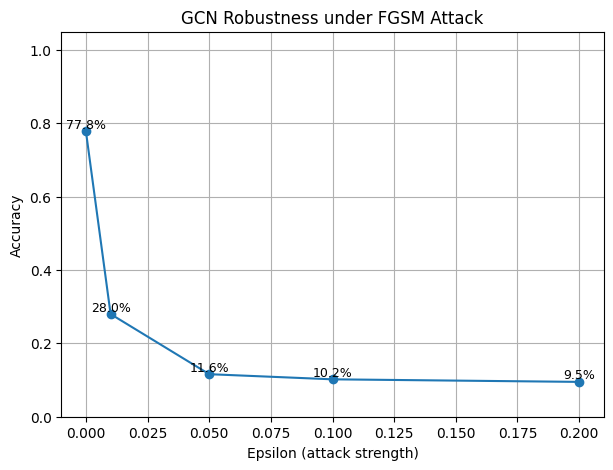

In [19]:
import matplotlib.pyplot as plt

# Evaluate clean accuracy
clean_acc = test()
print(f"Clean Test Accuracy (before attack): {clean_acc:.4f}")

# Track results
epsilons = [0.0, 0.01, 0.05, 0.1, 0.2]
accuracies = [clean_acc]

for eps in epsilons[1:]:
    perturbed_x = fgsm_attack(model, data, epsilon=eps, save_features=True)
    out_perturbed = model(perturbed_x, data.edge_index)
    pred = out_perturbed.argmax(dim=1)
    acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    accuracies.append(acc)

# Plot results with percentages
plt.figure(figsize=(7,5))
plt.plot(epsilons, accuracies, marker='o', linestyle='-')

for i, acc in enumerate(accuracies):
    plt.text(epsilons[i], acc, f"{acc*100:.1f}%", fontsize=9, ha='center', va='bottom')

plt.title("GCN Robustness under FGSM Attack")
plt.xlabel("Epsilon (attack strength)")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)  # keep y-axis between 0 and 100%
plt.grid(True)
plt.show()


In [20]:
# Function to plot the interactive graph
def plot_interactive_graph():
    # Create a NetworkX graph from edge index
    edge_index = data.edge_index.cpu().numpy()  # Convert to NumPy array
    G = nx.Graph()

    # Add edges to the graph
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])

    # Node labels and colors
    labels = {i: dataset[0].y[i].item() for i in range(data.num_nodes)}  # Node labels based on class
    colors = np.array([dataset[0].y[i].item() for i in range(data.num_nodes)])  # Node colors based on class

    # Create position layout for nodes
    pos = nx.spring_layout(G, k=0.5, iterations=50)  # Positioning of nodes

    # Prepare data for Plotly
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)  # None to break lines between edges
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)  # None to break lines between edges

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    node_x = []
    node_y = []
    node_color = []
    for i in range(data.num_nodes):
        x, y = pos[i]
        node_x.append(x)
        node_y.append(y)
        # Generate monochromatic color based on the class
        node_color.append(f'rgba(0, 0, {255 - (colors[i] * 25)}, 0.7)')  # Blue shades based on class

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        marker=dict(showscale=True,
                    colorscale='Blues',
                    size=10,
                    color=node_color,
                    line=dict(width=2)),
        text=[f'Node {i}: {labels[i]}' for i in range(data.num_nodes)]
    )

    # Create the figure
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Interactive Graph Visualization of the Cora Dataset',
                        titlefont=dict(size=16),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0,l=0,r=0,t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))

    pyo.iplot(fig)  # Use pyo.plot(fig) if you're using a script outside Jupyter Notebook

# Call the function to plot the interactive graph
plot_interactive_graph()

In [21]:
def plot_graph_with_predictions(model, features):
    model.eval()
    out = model(features, data.edge_index)
    pred = out.argmax(dim=1).cpu().numpy()

    edge_index = data.edge_index.cpu().numpy()
    G = nx.Graph()
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])

    # Use predictions instead of ground truth labels
    labels = {i: pred[i] for i in range(data.num_nodes)}
    colors = np.array(pred)

    pos = nx.spring_layout(G, k=0.5, iterations=50)

    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(x=edge_x, y=edge_y,
                            line=dict(width=0.5, color='#888'),
                            hoverinfo='none',
                            mode='lines')

    node_x, node_y, node_color = [], [], []
    for i in range(data.num_nodes):
        x, y = pos[i]
        node_x.append(x)
        node_y.append(y)
        node_color.append(f'rgba({colors[i]*40}, 0, {255-colors[i]*40}, 0.7)')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        hoverinfo='text',
        marker=dict(showscale=True,
                    colorscale='Blues',
                    size=10,
                    color=node_color,
                    line=dict(width=2)),
        text=[f'Node {i}: Pred {labels[i]}' for i in range(data.num_nodes)]
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Graph Predictions (with attack)',
                        titlefont=dict(size=16),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0,l=0,r=0,t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                    ))

    pyo.iplot(fig)


In [24]:
# Clean predictions
plot_graph_with_predictions(model, data.x)

# Perturbed predictions (after FGSM)
perturbed_x = fgsm_attack(model, data, epsilon=0.05)
plot_graph_with_predictions(model, perturbed_x)


Accuracy under FGSM attack (epsilon=0.05): 0.1160
